##  Temperature Correlations
At the OOI Coastal Pioneer Offshore Surface Mooring (CP04OSSM)

*By Sage Lichtenwalner, 2/1/2019*

For this example, I requsted data for the instrument CP04OSSM-SBD11-06-METBKA000 using the [OOI Data Portal](https://ooinet.oceanobservatories.org).  If you prefer to do everything in code, you can also request data using the OOI API by following this [quickstart example](https://github.com/ooi-data-review/2018-data-workshops/blob/master/chemistry/examples/quickstart_python.ipynb).

In [1]:
# First, import required libraries
import requests
import os
import re
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns # package for nice plotting defaults
sns.set()

In [2]:
# Specify the THREDDS dataset directory provided in the email 
url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage-marine-rutgers/20190111T154505-CP04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html'

In [3]:
# Now let's find all the data files we need
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
selected_datasets = []
for d in datasets:
    if 'VELPT' in d:
        pass
    else:
        selected_datasets.append(d)

In [4]:
# Open the dataset using xarray
ds = xr.open_mfdataset(selected_datasets)
ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
ds = ds.chunk({'time': 100}) # Used for optimization
ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by timestamp

In [5]:
# Pull the source attribute to make sure we have the right dataset
source = ds.source
source

'CP04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument'

## Hourly Average

In [6]:
# Let's specify just the variables we want to keep
ds2 = ds[['sea_surface_temperature','air_temperature']]

In [7]:
# Next we'll downsample from minute data to hourly and convert to a Pandas Dataframe
ds2 = ds2.resample(time='1H').mean()

In [8]:
ds2 = ds2.to_dataframe()

/Users/sage/miniconda3/envs/datavis/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [9]:
ds2['month'] = ds2.index.month
ds2.head()

,sea_surface_temperature,air_temperature,month
time,,,
2018-01-01 00:00:00,11.913067,-3.973300,1
2018-01-01 01:00:00,11.912951,-4.119117,1
2018-01-01 02:00:00,11.890484,-4.391334,1
2018-01-01 03:00:00,11.861517,-4.554717,1
2018-01-01 04:00:00,11.873700,-4.559850,1


## Time to make a plot

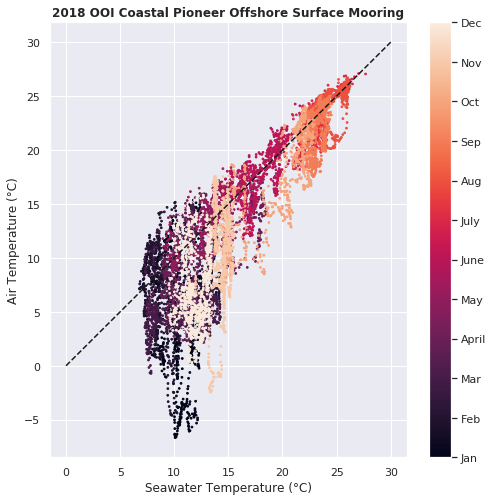

In [10]:
# Finally, let's make a pretty plot of the raw (essentially hourly) data
fig, (ax) = plt.subplots(1,1, figsize=(8,8))
# sns.scatterplot(x='sea_surface_temperature', y='air_temperature', data=ds2, hue='month');
plt.scatter(ds2['sea_surface_temperature'],ds2['air_temperature'],c=ds2['month'],s=3);
plt.xlabel('Seawater Temperature (°C)')
plt.ylabel('Air Temperature (°C)')
plt.title('2018 OOI Coastal Pioneer Offshore Surface Mooring',fontweight='bold');
plt.axis('equal');

# Add unitiy line
plt.plot([0,30],[0,30],'k--');

# Add colorbar
cbar = plt.colorbar(label='')
cbar.set_ticks(range(1,13,1))
cbar.set_ticklabels(['Jan','Feb','Mar','April','May','June','July','Aug','Sep','Oct','Nov','Dec'])

## Correlation

In [11]:
c = ds2.corr()
c

,sea_surface_temperature,air_temperature,month
sea_surface_temperature,1.000000,0.878642,0.445143
air_temperature,0.878642,1.000000,0.360319
month,0.445143,0.360319,1.000000


In [12]:
r2 = c['sea_surface_temperature']['air_temperature']**2
r2

0.7720114167093225